#Setting up a project

*Tutors*:
-- Federico Milanesio: federico.milanesio@unito.it
-- Davide Pirovano: davide.pirovano@unito.it

<div>
<img src="https://imgs.xkcd.com/comics/data_pipeline.png" width="850"/>
</div>

In [ ]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision

import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Where to set up a project

Here are some considerations for different environments and tools:

1. **Google Colab (Cloud-Based):**
   - **Pros:**
     - **Free GPU/TPU Access:** Google Colab provides free access to GPUs and TPUs, which can significantly accelerate model training for large datasets or complex models.
     - **Integrated Environment:** Colab offers a Jupyter notebook-like interface with pre-installed libraries (e.g., TensorFlow, PyTorch), making it easy to start coding without setup.
     - **Collaboration:** Shareable notebooks enable collaborative work and real-time editing with others.
   - **Cons:**
     - **Limited Session Duration:** Sessions can time out after a certain period of inactivity, potentially disrupting long-running experiments.
     - **Resource Constraints:** Limited GPU/TPU availability and memory constraints compared to dedicated cloud instances.

2. **Local Environment (with Jupyter Notebooks):**
   - **Pros:**
     - **Full Control:** Use of local hardware resources (CPU/GPU) provides more control over computation and data privacy.
     - **Offline Access:** Work without internet connectivity and access local files seamlessly.
   - **Cons:**
     - **Resource Limitations:** Performance may be limited by local hardware specifications, especially for large-scale tasks.
     - **Isolation:** Limited collaboration features compared to cloud-based platforms.



**Best Practices:**
- **[GitHub](https://github.com/):** track changes, collaborate, and manage project history effectively. Ensure reproducibility by versioning code, data, and environment configurations. If you do it right, you will have a **portfolio of your work** at the end of your university career.
- Combine local development with cloud-based resources.
- Regularly back up important project files.

# Finding a dataset

Here are some platforms to start from when you search a machine learning dataset:

- [Kaggle](https://www.kaggle.com/): Kaggle is a well-known platform for data science competitions and datasets. It hosts a wide range of datasets across various domains. You can **download datasets directly from Kaggle into Google Colab** using the Kaggle API or by manually downloading and uploading the dataset files.

- [UCI Machine Learning Repository](https://archive.ics.uci.edu/): The UCI Machine Learning Repository is a collection of databases, domain theories, and data generators. It provides datasets that are widely used for machine learning research. You can download datasets from the UCI repository and upload them to Google Colab.

- [GitHub](https://github.com): GitHub hosts many repositories containing machine learning datasets. You can search for repositories specifically designed for datasets or explore **popular repositories** related to machine learning.
  - [Public datasets](https://github.com/awesomedata/awesome-public-datasets
)
  - [Public (italian) datasets](https://github.com/italia/awesome-italian-public-datasets)

  - [Gaming datasets](https://github.com/leomaurodesenv/game-datasets)

- [OpenML](https://www.openml.org/): OpenML is an online platform that allows researchers to share and collaborate on machine learning datasets and experiments. It provides an API to access datasets programmatically, making it **easy to integrate** with Google Colab.

# Uploading your data

We have chosen [this](https://www.kaggle.com/datasets/ikjotsingh221/animal-dataset) dataset from Kaggle, a collection of photos of bears, crows, elephants, and rats.

You should first make a Kaggle account (if you don't have one already). To directly upload a dataset from Kaggle, go to `settings` of your Kaggle account --> `API` --> `Create New Token`. This will downlaod a `kaggle.json` file. Now upload this file to you Google Drive (I placed it in a folder called `kaggle`)

We install kaggle module for Python (if we don't have it already installed):

In [ ]:
!pip install kaggle

And we mount our Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We create a new (hidden) folder to store our kaggle API token, and we move it from our Drive to this folder:

In [ ]:
! mkdir /content/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle/kaggle.json /content/.kaggle/

cp: cannot stat '/content/drive/MyDrive/kaggle/kaggle.json': No such file or directory


In [ ]:
! chmod 600 /content/.kaggle/kaggle.json

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory


We then download the dataset to our `content` folder and we unzip it:

In [ ]:
! kaggle datasets download ikjotsingh221/animal-dataset --force

Dataset URL: https://www.kaggle.com/datasets/ikjotsingh221/animal-dataset
License(s): unknown
 92% 57.0M/62.3M [00:00<00:00, 153MB/s]
100% 62.3M/62.3M [00:00<00:00, 156MB/s]


In [ ]:
! unzip /content/animal-dataset.zip

Archive:  /content/animal-dataset.zip
  inflating: dataset/Testing/bears/k4 (100).jpeg  
  inflating: dataset/Testing/bears/k4 (100).jpg  
  inflating: dataset/Testing/bears/k4 (101).jpeg  
  inflating: dataset/Testing/bears/k4 (101).jpg  
  inflating: dataset/Testing/bears/k4 (102).jpeg  
  inflating: dataset/Testing/bears/k4 (102).jpg  
  inflating: dataset/Testing/bears/k4 (103).jpeg  
  inflating: dataset/Testing/bears/k4 (104).jpeg  
  inflating: dataset/Testing/bears/k4 (105).jpeg  
  inflating: dataset/Testing/bears/k4 (106).jpeg  
  inflating: dataset/Testing/bears/k4 (107).jpeg  
  inflating: dataset/Testing/bears/k4 (108).jpeg  
  inflating: dataset/Testing/bears/k4 (109).jpeg  
  inflating: dataset/Testing/bears/k4 (110).jpeg  
  inflating: dataset/Testing/bears/k4 (71).jpg  
  inflating: dataset/Testing/bears/k4 (72).jpeg  
  inflating: dataset/Testing/bears/k4 (72).jpg  
  inflating: dataset/Testing/bears/k4 (73).jpeg  
  inflating: dataset/Testing/bears/k4 (73).jpg  
  in

We define a function to check if an image is not **deprecated**:

In [ ]:
import os
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = False   # attempting to load truncated images will result in an error

def is_not_truncated(file_path):
  try:
    # Attempt to open and load the image file
    with Image.open(file_path) as img:
      img.load()
      return True        # Image file is not truncated
  except OSError:
    return False         # Image file is truncated or cannot be opened


We no load our dataset, we use a standard normalization for images (that may not always be the best one). We also **resize our images** to have dimensions `32x32`. Doing this loses a lot of information, but allows us to have faster training. Whether to resize your images or not, and by how mucg, depends on factors such as task complexity, available time, available processing resources and target performance.



In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

n = 32

transform = transforms.Compose([
    transforms.Resize((n, n)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

train_dataset = datasets.ImageFolder('/content/dataset/Training',
                                     transform=transform,
                                     is_valid_file = is_not_truncated)

val_dataset = datasets.ImageFolder('/content/dataset/Testing', transform=transform, is_valid_file = is_not_truncated)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last = True)


We show the images (before normalization):

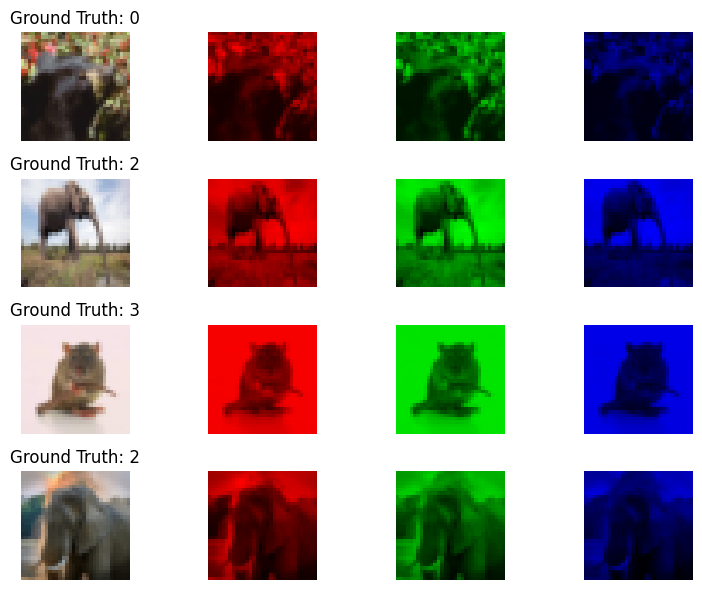

In [ ]:
import copy

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

num_rows = 4
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  img = example_data[i].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5

  r = copy.deepcopy(img)
  r[:,:,1] = r[:,:,2] = 0

  g = copy.deepcopy(img)
  g[:,:,0] = g[:,:,2] = 0

  b = copy.deepcopy(img)
  b[:,:,1] = b[:,:,0] = 0

  axes[i, 0].imshow(img)
  axes[i, 1].imshow(r)
  axes[i, 2].imshow(g)
  axes[i, 3].imshow(b)

  axes[i, 0].set_title("Ground Truth: {}".format(example_targets[i]))

  axes[i,0].axis('off')
  axes[i,1].axis('off')
  axes[i,2].axis('off')
  axes[i,3].axis('off')

plt.tight_layout()
plt.show()

**Exercise 1:** Could this dataset benefit from data augmentation? What specific transformations might be helpful here?

In [ ]:
...

Ellipsis

# Choosing a model

If you want to download a pre-trained model, and perform **fine-tuning** on them, TorchVision comes bundled with a useful [library](https://pytorch.org/vision/stable/models.html), with models such as ResNet, VGG, DenseNet, AlexNet, and more. These models are trained on standard benchmark datasets like ImageNet and are widely used for various computer vision tasks, including image classification, object detection, segmentation, and more. To load one you just need this few lines:


```
import torchvision.models as models

model = models.mobilenet_v3_small(weights = models.MobileNet_V3_Small_Weights.DEFAULT)
```



We will instead write a model ourselves.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=(5,5), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(5,5), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=(5,5), stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)

        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=0.2)                   # Adjust dropout probability as needed

        self.fc1 = nn.Linear((n-16)**2//4, 16)
        self.fc2 = nn.Linear(16, 4)

        self.output = nn.Softmax(dim = 1)

    def forward(self, x):
        # Input shape: (batch_size, 3, n, n)

        x = self.activation(self.bn1(self.conv1(x)))       # Output shape: (batch_size, 16, n-2, n-2)
        x = self.pooling(x)                                # Output shape: (batch_size, 16, n/2 - 1, n/2 - 1)
        x = self.dropout(x)

        x = self.activation(self.bn2(self.conv2(x)))       # Output shape: (batch_size, 16, n/2 - 3, n/2 - 3)
        x = self.pooling(x)                                # Output shape: (batch_size, 16, n/4 - 2, n/4 - 2)
        x = self.dropout(x)

        x = self.activation(self.bn3(self.conv3(x)))       # Output shape: (batch_size, 16, n/4 - 4, n/4 - 4)
        x = self.pooling(x)                                # Output shape: (batch_size, 16, n/8 - 2, n/8 - 2)
        x = self.dropout(x)

        x = torch.flatten(x, 1)                            # Output shape: (batch_size, (n-16)^2/4)

        x = self.activation(self.fc1(x))                   # Output shape: (batch_size, 16)
        x = self.dropout(x)
        x = self.fc2(x)                                    # Output shape: (batch_size, 1)

        return self.output(x)

model = CNN().to(device)

if device.type == "cuda:0":
  model = torch.compile(model, dynamic=True)
  model = model.to(device)
else:
  model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)

In [ ]:
loss_function = nn.CrossEntropyLoss()

We will use some modified versions of the functions of the previous notebook (there is nothing knew, just a reshuffling):

In [ ]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

def loader_accuracy(model, loader):

  with torch.no_grad():

    acc = 0

    for x, y in loader:

      x, y = x.to(device), y.to(device)

      acc += accuracy(model(x).squeeze(), y)

    return (acc/len(loader)*100).cpu()

def step(model, x, y, optimizer = None):

  out = model(x)
  loss = loss_function(out.squeeze(), y)

  if optimizer is not None:

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return loss.detach().cpu()

def evaluate(model, loader, early_stopping = None):

  with torch.no_grad():

    loss = 0

    # Calculate validation metric (e.g., validation loss)
    for inputs, targets in loader:

      inputs, targets = inputs.to(device), targets.to(device)
      loss += step(model, inputs, targets)

    loss /= len(loader)

   # Check for early stopping
    if early_stopping is not None:
      early_stopping(loss, model)

    return loss.detach().cpu()


if device.type != "cpu":
  accuracy = torch.compile(accuracy)
  train = torch.compile(step)
else:
  accuracy = torch.compile(accuracy, mode = "max-autotune-no-cudagraphs", dynamic=True)
  train = torch.compile(step, mode = "max-autotune-no-cudagraphs", dynamic=True)


# Early stopping

Implementing early stopping in PyTorch involves monitoring a validation metric (such as validation loss or accuracy) during model training and terminating the training process when the metric stops improving or starts deteriorating. This technique helps prevent overfitting and ensures that the model generalizes well on unseen data.

In [ ]:
# this code is taken from https://github.com/Bjarten/early-stopping-pytorch
# Copyright (c) 2018 Bjarte Mehus Sunde under MIT License
# to see full license consult the NOTICE.txt file on the Github repository from which this notebook is taken from

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)


The function `torch.save(model.state_dict(), path)` is used in PyTorch to save the state dictionary (`state_dict`) of a model to a specified file path (`path`).


- `model.state_dict()` returns a dictionary object containing the **current state of the model's parameters**. This dictionary maps each parameter's name (key) to its corresponding tensor value (value).
- The state dictionary (`state_dict`) typically includes **all learnable parameters** (e.g., weights and biases) of the model.

- `torch.save(obj, f)` is a function in PyTorch used to ìserialize and save an objectì (`obj`) to a file (`f`) using Python's `pickle` serialization. When `obj` is a model's state dictionary (`model.state_dict()`), `torch.save()` **serializes the dictionary and saves it** to the specified file path (`f`).

In [ ]:
! mkdir /content/.checkpoints

In [ ]:
EPOCHS = 21

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

early_stopping = EarlyStopping(patience=4, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')


for epoch in range(EPOCHS):

  ## TRAIN STEP

  model.train()

  train_loss = 0

  for x_train, y_train in train_loader:

    x_train, y_train = x_train.to(device), y_train.to(device)

    loss = step(model, x_train, y_train, optimizer)

    train_loss += loss

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  ## TEST STEP

  model.eval()

  train_acc = loader_accuracy(model, train_loader)
  val_acc = loader_accuracy(model, val_loader)

  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  val_loss = evaluate(model, val_loader, early_stopping)
  val_losses.append(val_loss.cpu())

  print("Epoch:", epoch, f"Train: {float(train_acc):.2f}%,  Validation: {float(val_acc):.2f}%,")

  if early_stopping.early_stop:
      print("Early stopping triggered.")
      break


W0527 13:12:30.956000 134107760455680 torch/_inductor/utils.py:945] [0/0] not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(32x4, 32x16, 16x4)
  bias_addmm 0.0135 ms 100.0%
  addmm 0.0150 ms 89.8%
SingleProcess AUTOTUNE takes 0.3962 seconds


Epoch: 0 Train: 49.75%,  Validation: 51.56%,
Epoch: 1 Train: 48.03%,  Validation: 51.56%,
Epochs without improvement: 1
Epoch: 2 Train: 49.67%,  Validation: 52.19%,
Epoch: 3 Train: 62.50%,  Validation: 66.56%,
Epochs without improvement: 1
Epoch: 4 Train: 50.33%,  Validation: 55.94%,
Epoch: 5 Train: 72.70%,  Validation: 77.81%,
Epochs without improvement: 1
Epoch: 6 Train: 67.76%,  Validation: 73.75%,
Epoch: 7 Train: 71.79%,  Validation: 78.75%,
Epochs without improvement: 1
Epoch: 8 Train: 67.60%,  Validation: 68.75%,
Epoch: 9 Train: 77.14%,  Validation: 80.31%,
Epochs without improvement: 1
Epoch: 10 Train: 71.22%,  Validation: 75.94%,
Epochs without improvement: 2
Epoch: 11 Train: 76.15%,  Validation: 78.44%,
Epoch: 12 Train: 78.54%,  Validation: 80.62%,
Epoch: 13 Train: 80.10%,  Validation: 86.88%,
Epochs without improvement: 1
Epoch: 14 Train: 78.21%,  Validation: 84.38%,
Epochs without improvement: 2
Epoch: 15 Train: 74.59%,  Validation: 81.25%,
Epochs without improvement: 3
Epoc

We can load the best model with:

In [ ]:
model.load_state_dict(torch.load('/content/.checkpoints/model_checkpoint.pt'))

<All keys matched successfully>

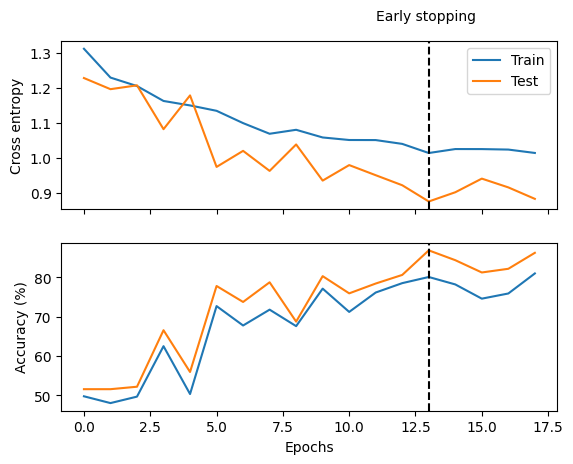

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(train_losses, label = "Train")
ax[0].plot(val_losses, label = "Test")

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)
ax[0].vlines(np.argmin(val_losses), ymin=ymin, ymax=ymax, color = 'black', linestyle = '--')
ax[0].text(x = np.argmin(val_losses) - 2, y = (ymax+ymin)/2 + 0.3, s = "Early stopping")
ax[0].legend()

ax[0].set_ylabel("Cross entropy")

ax[1].plot(train_accuracies, label = "Train")
ax[1].plot(val_accuracies, label = "Test")
ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(ymin, ymax)
ax[1].vlines(np.argmin(val_losses), ymin=ymin, ymax=ymax, color = 'black', linestyle = '--', )

ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")

plt.show()

**Exercise 2:** what do you think of these performances? What should you compare them to?

# Parameter tuning

Hyperparameter tuning involves selecting the optimal values for various hyperparameters of a deep learning model to achieve the **best performance** on a given task or dataset. Hyperparameters are parameters that are set before the learning process begins and cannot be directly learned from the data, unlike model parameters (weights and biases).

In [ ]:
def train_model(lrs = [0.01], max_epochs = 100):

  results = []

  for learning_rate in lrs:

    print("Starting with lr:", learning_rate)
    model = CNN().to(device)

    if device.type == "cuda:0":
      model = torch.compile(model, dynamic=True)
      model = model.to(device)
    else:
      model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    early_stopping = EarlyStopping(patience=4, verbose=False, path=f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt')

    for epoch in range(max_epochs):

      ## TRAIN STEP

      model.train()

      for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)
        step(model, x_train, y_train, optimizer)

      ## TEST STEP

      model.eval()

      val_loss = evaluate(model, val_loader, early_stopping)

      if early_stopping.early_stop:
          break

    model.load_state_dict(torch.load(f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt'))

    train_acc = loader_accuracy(model, train_loader)
    val_acc = loader_accuracy(model, val_loader)

    train_loss = evaluate(model, train_loader)
    val_loss = evaluate(model, val_loader)

    results.append([train_loss, val_loss, train_acc, val_acc])
    print(f"\tTrain loss: {train_loss:.3f} and validation loss: {val_loss:.3f}\n\tTrain accuracy: {train_acc:.2f}% and valiation accuracy: {val_acc:.2f}%\n\n")

  return results

In [ ]:
lrs = [0.01, 0.02, 0.03, 0.04, 0.05]
results = train_model(lrs, max_epochs = 20)

Starting with lr: 0.01
	Train loss: 0.965 and validation loss: 0.901
	Train accuracy: 77.47% and valiation accuracy: 84.69%


Starting with lr: 0.02
	Train loss: 1.032 and validation loss: 0.962
	Train accuracy: 70.64% and valiation accuracy: 77.81%


Starting with lr: 0.03
	Train loss: 1.124 and validation loss: 1.061
	Train accuracy: 61.02% and valiation accuracy: 67.81%


Starting with lr: 0.04
	Train loss: 1.139 and validation loss: 1.099
	Train accuracy: 60.20% and valiation accuracy: 64.38%


Starting with lr: 0.05
	Train loss: 1.182 and validation loss: 1.146
	Train accuracy: 55.76% and valiation accuracy: 58.44%




In [ ]:
results = np.array(results).T

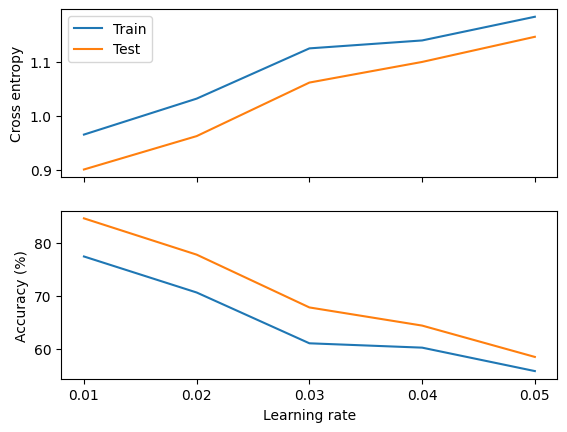

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(lrs, results[0], label = "Train")
ax[0].plot(lrs, results[1], label = "Test")

ax[0].legend()

ax[0].set_ylabel("Cross entropy")

ax[1].plot(lrs, results[2], label = "Train")
ax[1].plot(lrs, results[3], label = "Test")


ax[1].set_xlabel("Learning rate")
ax[1].set_ylabel("Accuracy (%)")

ax[1].set_xticks(lrs)

plt.show()


**Exercise 3:** What are the limitations of this search method? How should it be improved? Which parameters should we tune?

# Model interpretation

There are many things you can try on you model to evaluate performance other than accuracy. One such thing is the **confusion matrix**, that makes it easier to interpret and communicate the model's performance. This visual aid helps in understanding which classes are well-predicted and which require improvement.

We select the best model:

In [ ]:
best_lr = lrs[np.argmin(results[1])]

print(f"The best learning rate is {best_lr}")

model.load_state_dict(torch.load(f'/content/.checkpoints/model_checkpoint_{best_lr}.pt'))
model = model.to(device)

The best learning rate is 0.01


In [ ]:
model.load_state_dict(torch.load(f'/content/.checkpoints/model_checkpoint_{0.01}.pt'))
model = model.to(device)

In [ ]:
from sklearn.metrics import confusion_matrix

model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in val_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[0.91 0.   0.08 0.01]
 [0.03 0.9  0.06 0.01]
 [0.06 0.   0.89 0.05]
 [0.04 0.03 0.28 0.65]]


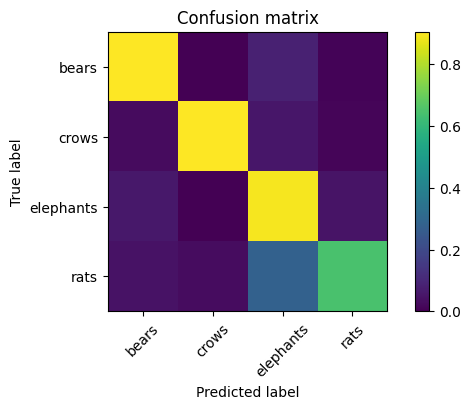

In [ ]:
classes =val_dataset.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

Another tool we can use are **saliency maps**, that provide visual explanations of the model's decision-making process by highlighting the regions of the input image that are most influential in predicting a particular class. This can bring forth error in the classification process (for example if the model bases its predictions on features that are not relevant for the task)

$SM_{ijk} = \dfrac{\partial y_{predicted}}{\partial x_{ijk}} $

$ i \in \{1,\dots,n_{channels}\}$

$ j \in \{1,\dots, W\}$

$ k \in \{1,\dots, H\}$

In [ ]:
def generate_saliency_map(model, X):

    model.eval()

    saliency_map = []

    for i in range(X.size(0)):

      x = copy.copy(X[i:i+1])  # we create a copy of the image
      x = x.to(device)
      x.requires_grad = True

      output = model(x).squeeze()

      _, target_class = torch.max(output, -1) # we get the predict class (similar to argmax)

      model.zero_grad()
      output[target_class].backward()

      gradients = x.grad

      map, _ = torch.max(gradients.abs().squeeze(), dim=0) # we get the maximum across channels

      saliency_map.append(map.cpu().detach().numpy())
      saliency_map[i] = (saliency_map[i]- saliency_map[i].min())/(saliency_map[i].max() - saliency_map[i].min())  # we scale saliency map in range [0,1]
      x.requires_grad = False

    return np.array(saliency_map)

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
saliency_map = generate_saliency_map(model, example_data)

AUTOTUNE addmm(1x4, 1x16, 16x4)
  bias_addmm 0.0079 ms 100.0%
  addmm 0.0114 ms 69.7%
SingleProcess AUTOTUNE takes 0.2235 seconds


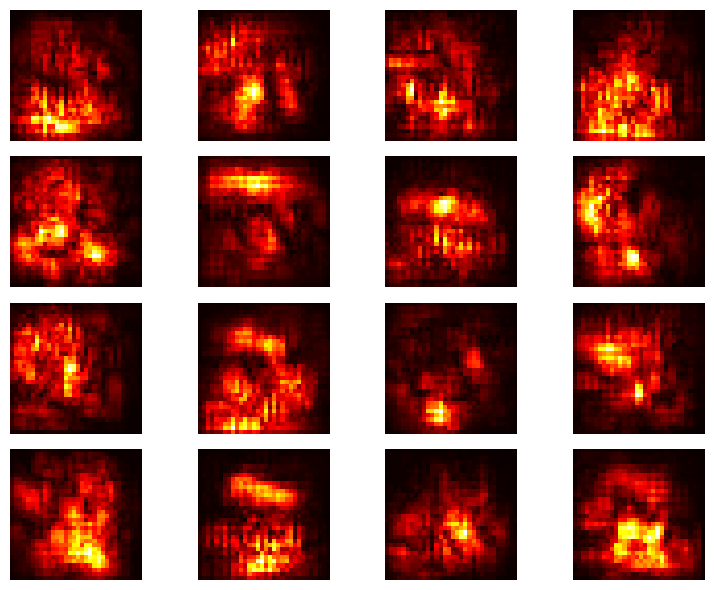

In [ ]:
from matplotlib import colormaps

num_rows = 4
num_cols = 4

colormap = colormaps["hot"] #select a colormap

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j]) # Apply colormap to saliency map

    axes[i, j].imshow(transforms.ToPILImage()(sm))

    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

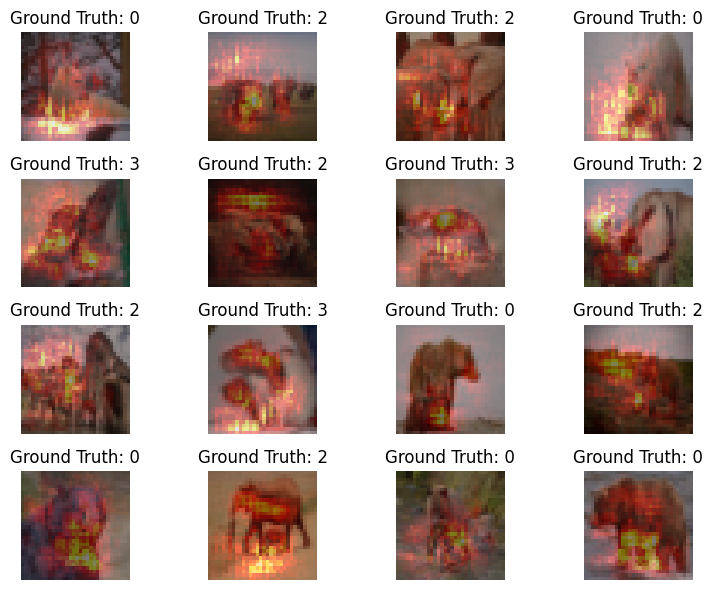

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j])[:, :, :3]  # Apply colormap to saliency map

    axes[i, j].imshow(Image.blend(Image.fromarray(img), transforms.ToPILImage()(sm), alpha = 0.4))


    axes[i, j].set_title("Ground Truth: {}".format(example_targets[4*i + j]))

    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

# What now?

Here is a list of questions you should ask yourself when training a Neural Network (or you should be ready to answer when they will be asked by a *certain professor*). This list is **NOT complete**, but can give you a good starting point to make a good impression. You also **don't have to do all** the things written here, but I highly recommend you give it a read and be prepared if any of these questions comes up

**Before strating:**

- What questions am I **trying to answer** with this project?

- What **performance** am I aiming for?

- Are there models already trained on this task? Is **transfer learning** an option?

- Are there **potential biases** in training data and algorithms that could lead to unfair outcomes (e.g., racial, gender, or socioeconomic biases)?

**Preprocessing:**

- Did I handle **missing or corrupted data** appropriately?

- Are my **classes balanced**?
  - Consider examining the distribution of classes in your dataset. Imbalanced classes can lead to biased model predictions. Techniques such as oversampling, undersampling, or using class weights can help address class imbalance.

- What **preprocessing** did I perform on my data? Did I normalize them?

- Did I perform **data augmentation**? Why/why not?


- How did I divide my data between **train/validation/test**?
  - Describe the method used to split the dataset into training, validation, and test sets (e.g., random split, stratified split), as well as the number of samples in each set.

- Have I applied feature engineering or **extraction techniques**?
  - Discuss any feature engineering methods used to enhance the representation of input data (e.g., feature scaling, dimensionality reduction) before feeding it into the neural network.


**Model Training:**

- Which **loss function** did I choose? Why? Should I try others?

- How did I choose my **model architecture**?

- How did I **tune** parameters? (e.g., grid search, random search, Bayesian optimization)
  - [grid search](https://scikit--learn-org.translate.goog/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?_x_tr_sl=en&_x_tr_tl=it&_x_tr_hl=it&_x_tr_pto=sc): implementation of grid search in scikit learn
  -[ray tuning](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html): a scalable hyperparameter tuning library designed to simplify the process of tuning machine learning models

- Did I implement any form of **regularization**?

- Did I implement **early stopping**?

- Did I monitor and **visualize model training progress**?

- Did I implement **learning rate scheduling**? Why/why not?

- How did I handle **model checkpoints** and saving/loading trained models?


**After Training:**

- Have I conducted model performance comparison with **baseline models**?
  - You should always compare the performance of your model to simple Linear Regression/Logistic Regression. If your model cannot outperform them, you need to go back to the drawing board

- Did I use **additional evaluation** metrics beyond accuracy?
  - For example other evaluation metrics such as precision, recall, F1-score, and confusion matrix to provide a comprehensive assessment of model performance.

- If I have only two classes, did I plot a **Precision-Recall graph**?
  - Especially when dealing with imbalanced datasets or when class distributions are skewed.

- Which samples does the model **struggle to classify**?

- If there are more than two classes, **which classes are confused** more often?






**One last tip**: no matter what you choose to use, be sure to know the theory behind it. It is better to use a **simple model you understand** than a complicated one you don't.

*© 2024. This work is openly licensed via [CC BY-NC-SA 4.0 DEED](https://creativecommons.org/licenses/by-nc-sa/4.0/)*

*Comics used in the notebooks are from [xkcd.com](https://xkcd.com), and are licensed under the Creative Commons Attribution-NonCommercial 2.5 license.*

*Details and usage notes can be found at [xkcd.com/license.html](https://xkcd.com/license.html).*